### Task 1: Tabular Q-Learning Update

In [6]:
import numpy as np
def init_q_table(n_states, n_actions):
    table = np.zeros((n_states,n_actions))
    return table

def q_update(Q,s,a,r,s_next,lr,df):
    Q[s,a] = Q[s,a] + lr(r + df*np.max(Q[s_next]) - Q[s,a])
    return Q

### Task 2: ε-Greedy Policy on a Custom GridWorld

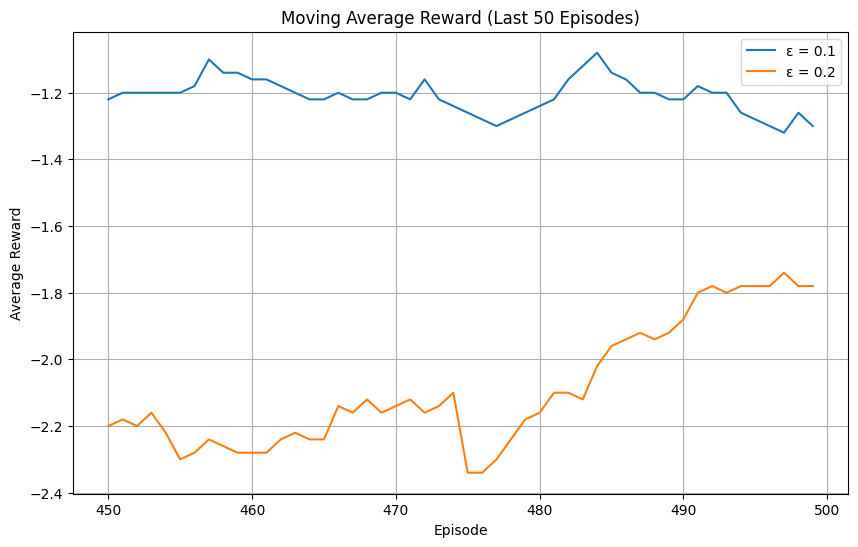

In [12]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld:
    def __init__(self, size=4):
        self.size = size
        self.terminal_positions = [(0, 0), (size - 1, size - 1)]
        self.action_space = 4  

    def reset(self):
        while True:
            row = np.random.randint(self.size)
            col = np.random.randint(self.size)
            if (row, col) not in self.terminal_positions:
                break
        self.pos = (row, col)
        return self.pos

    def step(self, action):
        row, col = self.pos

        if (row, col) in self.terminal_positions:
            return (row, col), 0, True

        if action == 0 and row > 0:
            row -= 1  
        elif action == 1 and row < self.size - 1:
            row += 1  
        elif action == 2 and col > 0:
            col -= 1  
        elif action == 3 and col < self.size - 1:
            col += 1  

        self.pos = (row, col)
        reward = 0 if self.pos in self.terminal_positions else -1
        done = self.pos in self.terminal_positions
        return self.pos, reward, done

def select_action(Q, state, ε):
    row, col = state
    if np.random.rand() < ε:
        return np.random.randint(Q.shape[2])
    else:
        return np.argmax(Q[row, col])

def q_update(Q, s, a, r, s_next, α, γ):
    row, col = s
    next_row, next_col = s_next
    Q[row, col, a] += α * (r + γ * np.max(Q[next_row, next_col]) - Q[row, col, a])
    return Q

def train_agent(epsilon, episodes=500):
    env = GridWorld()
    Q = np.zeros((env.size, env.size, env.action_space))
    lr = 0.1  
    df = 0.95 
    rewards = []

    for ep in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = select_action(Q, state, epsilon)
            next_state, reward, done = env.step(action)
            Q = q_update(Q, state, action, reward, next_state, lr, df)
            state = next_state
            total_reward += reward

        rewards.append(total_reward)

    return rewards

def plot_results(rewards_01, rewards_02):
    def moving_average(data, window_size=50):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(10, 6))
    plt.plot(range(450, 500), moving_average(rewards_01)[-50:], label='ε = 0.1')
    plt.plot(range(450, 500), moving_average(rewards_02)[-50:], label='ε = 0.2')
    plt.title('Moving Average Reward (Last 50 Episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

rewards_e01 = train_agent(0.1)
rewards_e02 = train_agent(0.2)

plot_results(rewards_e01, rewards_e02)


Due to the high reward of the terminal cell, the epsilon=0.2 suffers in comparison to the epsilon=0.1 as it explores more rather than sticking to an optimal path to get the reward. However, it may benefit in the future as it seems to grow while the epsilon=0.1 seems to stabilize.

### Task 3: Experience Replay Buffer

In [14]:
import numpy as np
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (np.array(states),
                np.array(actions),
                np.array(rewards, dtype=np.float32),
                np.array(next_states),
                np.array(dones, dtype=bool))

    def __len__(self):
        return len(self.buffer)

buffer = ReplayBuffer(capacity=100)

for _ in range(100):
    state = np.random.randint(0, 16)
    action = np.random.randint(0, 4)
    reward = np.random.uniform(-1.0, 1.0)
    next_state = np.random.randint(0, 16)
    done = np.random.choice([True, False])
    buffer.push(state, action, reward, next_state, done)

batch_size = 32
states, actions, rewards, next_states, dones = buffer.sample(batch_size)

print("Shapes:")
print(f"States: {states.shape}, Actions: {actions.shape}, Rewards: {rewards.shape}, Next States: {next_states.shape}, Dones: {dones.shape}")

print("Data Types:")
print(f"States: {states.dtype}, Actions: {actions.dtype}, Rewards: {rewards.dtype}, Next States: {next_states.dtype}, Dones: {dones.dtype}")



Shapes:
States: (32,), Actions: (32,), Rewards: (32,), Next States: (32,), Dones: (32,)
Data Types:
States: int32, Actions: int32, Rewards: float32, Next States: int32, Dones: bool


### Task 4: Deep Q-Network with Target Copy


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQNPolicy(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(DQNPolicy, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

class DQNTarget(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(DQNTarget, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

### Task 5: Full DQN Training Loop on CartPole-v1

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt

# DQN Network
class DQN(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# Target Network Sync
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.ptr = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.ptr] = (state, action, reward, next_state, done)
        self.ptr = (self.ptr + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(zip(*batch))
        return (
            torch.tensor(state, dtype=torch.float32),
            torch.tensor(action, dtype=torch.int64),
            torch.tensor(reward, dtype=torch.float32),
            torch.tensor(next_state, dtype=torch.float32),
            torch.tensor(done, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

# ε-greedy action selection
def select_action(policy_net, state, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        return torch.argmax(policy_net(state_tensor)).item()

# Training loop parameters
N = 500           # total episodes
M = N             # epsilon decay episodes
X = 10            # target network update interval
EPS_START = 1.0
EPS_END = 0.01
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 10000
LEARNING_RATE = 1e-3

# Setup
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

policy_net = DQN(obs_dim, n_actions)
target_net = DQN(obs_dim, n_actions)
update_target(policy_net, target_net)

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()
replay_buffer = ReplayBuffer(BUFFER_SIZE)

# Training loop
episode_rewards = []
successes = 0

for episode in range(N):
    state = env.reset()
    total_reward = 0
    epsilon = max(EPS_END, EPS_START - (EPS_START - EPS_END) * (episode / M))

    done = False
    while not done:
        action = select_action(policy_net, state, epsilon, n_actions)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Train if enough samples
        if len(replay_buffer) >= BATCH_SIZE:
            states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

            # Compute target values
            with torch.no_grad():
                next_q = target_net(next_states).max(1)[0]
                target = rewards + GAMMA * next_q * (1 - dones)

            current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            loss = loss_fn(current_q, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    episode_rewards.append(total_reward)
    if total_reward >= 195:
        successes += 1

    # Update target network
    if (episode + 1) % X == 0:
        update_target(policy_net, target_net)

# Plot moving average
window = N // 10
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(moving_avg)
plt.xlabel("Episode")
plt.ylabel(f"Moving Average Reward (window={window})")
plt.title("CartPole DQN: Moving Average Reward")
plt.grid(True)
plt.show()

# Final success rate
success_rate = 100 * successes / N
print(f"\n✅ Final Success Rate: {success_rate:.2f}% (Episodes ≥ 195)")

TypeError: map() must have at least two arguments.